---
title: "Análisis Predictivo: Desistimiento de Clientes"
author: "Fabio Marulanda"
format:
  html:
    theme: zephyr
    toc: true
    toc-location: left
    code-fold: false     
execute:
  echo: true             
  warning: false
  message: false
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import lightgbm as lgb
import joblib
import plotly.express as px
import plotly.io as pio
import plotly.express as px
pio.renderers.default = "notebook_connected"
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_style("whitegrid")

In [2]:
#cargar datos

df = pd.read_excel("Data_bancaria.xlsx")

In [3]:
# EDA

df.head()

,SOLICITUD,FECHA_INICIO,MULTAS_SIMIT,EDAD,CUOTA_INICIAL,GENERO,ESTADO_CIVIL,NIVEL_ESTUDIO,TIPO_VIVIENDA,PERSONAS_CARGO,...,TIPO_CLIENTE,HABITO_PAGO,ENDEUDAMIENTO,CALIFICACION,CREDITOS_VIGENTES,Puntaje Riesgo,TIPO_CONTRATO,ANTIGUEDAD,Marca producto,Estado
0,1,2017-01-02,0.0,29,0,F,Divorciado,Tecnólogico,Arrendada,2,...,Independiente sin Establecimiento,B,85860.0,A,2,2190,Indefinido,10,Marca A,Aprobada
1,2,2017-01-02,0.0,60,1035000,F,Soltero,Tecnólogico,Arrendada,1,...,Independiente sin Establecimiento,E,1270940.0,C,9,2142,Por Obra o Labor,131,Marca A,Desistida
2,3,2017-01-02,0.0,61,472500,M,Divorciado,Tecnólogico,Arrendada,1,...,Independiente sin Establecimiento,E,664620.0,C,7,2073,Indefinido,63,Marca B,Anulada
3,4,2017-01-02,0.0,25,0,M,Casado,Tecnólogico,Arrendada,2,...,Independiente sin Establecimiento,B,51940.0,A,2,1929,Otra,12,Marca A,Negada
4,5,2017-01-02,0.0,30,3672000,F,Divorciado,Tecnólogico,Arrendada,3,...,Independiente sin Establecimiento,B,0.0,A,2,3,INDEPENDIENTE SIN ESTABLECIMIENTO,131,Marca A,Anulada


In [4]:
df.tail()

,SOLICITUD,FECHA_INICIO,MULTAS_SIMIT,EDAD,CUOTA_INICIAL,GENERO,ESTADO_CIVIL,NIVEL_ESTUDIO,TIPO_VIVIENDA,PERSONAS_CARGO,...,TIPO_CLIENTE,HABITO_PAGO,ENDEUDAMIENTO,CALIFICACION,CREDITOS_VIGENTES,Puntaje Riesgo,TIPO_CONTRATO,ANTIGUEDAD,Marca producto,Estado
33663,33664,2017-12-04,466798.20,40,900000,F,Casado,Tecnólogico,Arrendada,2,...,Independiente sin Establecimiento,E,270300.0,C,5,2205,Otra,5,Marca A,Desistida
33664,33665,2017-11-16,1522346.78,39,692910,F,Divorciado,Tecnólogico,Arrendada,3,...,Independiente sin Establecimiento,B,0.0,A,1,3,Indefinido,8,Marca A,Desistida
33665,33666,2017-11-21,0.00,25,1296000,F,Casado,Tecnólogico,Arrendada,1,...,Independiente sin Establecimiento,E,115540.0,A,3,1041,Libre Nombramiento,28,Marca A,Aprobada
33666,33667,2017-12-06,0.00,27,1116000,F,Casado,Tecnólogico,Propia sin hipoteca,3,...,Independiente sin Establecimiento,E,392200.0,C,5,2232,Por Obra o Labor,55,Marca A,Aprobada
33667,33668,2017-12-11,0.00,23,324000,F,Divorciado,Postgrado,Propia sin hipoteca,1,...,Independiente sin Establecimiento,B,0.0,A,0,21,Por Obra o Labor,24,Marca A,Desistida


In [5]:
df.describe()

,SOLICITUD,FECHA_INICIO,MULTAS_SIMIT,EDAD,CUOTA_INICIAL,PERSONAS_CARGO,PLAZO,VALOR_SOLICITADO,INGRESOS,EGRESOS,ENDEUDAMIENTO,CREDITOS_VIGENTES,Puntaje Riesgo,ANTIGUEDAD
count,33668.000000,33668,3.366800e+04,33668.000000,3.366800e+04,33668.000000,33668.000000,3.366800e+04,3.366800e+04,3.366800e+04,3.366800e+04,33668.000000,33668.000000,33668.000000
mean,16834.500000,2017-06-03 21:53:52.172983296,7.647234e+04,34.103956,6.283836e+05,2.042028,36.404360,4.833895e+06,1.768666e+06,7.119266e+05,3.764307e+05,2.421944,1379.838897,39.079066
min,1.000000,2017-01-02 00:00:00,0.000000e+00,-1.000000,0.000000e+00,1.000000,6.000000,5.250000e+05,0.000000e+00,0.000000e+00,-2.554600e+05,0.000000,0.000000,0.000000
25%,8417.750000,2017-04-06 00:00:00,0.000000e+00,26.000000,1.305000e+05,1.000000,36.000000,3.726450e+06,1.041600e+06,3.390000e+05,0.000000e+00,1.000000,21.000000,8.000000
50%,16834.500000,2017-06-10 00:00:00,0.000000e+00,31.000000,4.278240e+05,2.000000,36.000000,4.608450e+06,1.344000e+06,5.650000e+05,1.049400e+05,2.000000,1803.000000,19.000000
75%,25251.250000,2017-07-31 00:00:00,0.000000e+00,39.000000,7.380000e+05,3.000000,36.000000,5.782875e+06,1.792000e+06,7.684000e+05,3.498000e+05,3.000000,2139.000000,43.000000
max,33668.000000,2017-12-31 00:00:00,6.679191e+06,2000.000000,9.900000e+06,29.000000,60.000000,1.363950e+07,1.563520e+08,8.554100e+07,1.425000e+08,89.000000,2742.000000,637.000000
std,9719.258768,NaN,3.007114e+05,16.251590,7.663405e+05,1.010997,8.509071,1.473938e+06,2.215846e+06,1.360024e+06,1.624263e+06,2.571922,907.210098,55.645814


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33668 entries, 0 to 33667
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   SOLICITUD          33668 non-null  int64         
 1   FECHA_INICIO       33668 non-null  datetime64[ns]
 2   MULTAS_SIMIT       33668 non-null  float64       
 3   EDAD               33668 non-null  int64         
 4   CUOTA_INICIAL      33668 non-null  int64         
 5   GENERO             33668 non-null  object        
 6   ESTADO_CIVIL       33668 non-null  object        
 7   NIVEL_ESTUDIO      33668 non-null  object        
 8   TIPO_VIVIENDA      33668 non-null  object        
 9   PERSONAS_CARGO     33668 non-null  int64         
 10  ZONA               33668 non-null  object        
 11  PLAZO              33668 non-null  int64         
 12  CODEUDOR           33668 non-null  object        
 13  VALOR_SOLICITADO   33668 non-null  float64       
 14  INGRES

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.isna().sum()

SOLICITUD              0
FECHA_INICIO           0
MULTAS_SIMIT           0
EDAD                   0
CUOTA_INICIAL          0
GENERO                 0
ESTADO_CIVIL           0
NIVEL_ESTUDIO          0
TIPO_VIVIENDA          0
PERSONAS_CARGO         0
ZONA                   0
PLAZO                  0
CODEUDOR               0
VALOR_SOLICITADO       0
INGRESOS               0
EGRESOS                0
SUBTIPO_CLIENTE        0
TIPO_CLIENTE           0
HABITO_PAGO            0
ENDEUDAMIENTO          0
CALIFICACION           0
CREDITOS_VIGENTES      0
Puntaje Riesgo         0
TIPO_CONTRATO        377
ANTIGUEDAD             0
Marca producto         0
Estado                 0
dtype: int64

In [9]:
df["TIPO_CONTRATO"].unique()

array(['Indefinido', 'Por Obra o Labor', 'Otra',
       'INDEPENDIENTE SIN ESTABLECIMIENTO',
       'INDEPENDIENTE CON ESTABLECIMIENTO', 'Temporal',
       'Libre Nombramiento', 'Carrera Administrati', 'Provisionalidad',
       'Propiedad', 'Término Fijo', nan], dtype=object)

In [10]:
df["TIPO_CONTRATO"] = df["TIPO_CONTRATO"].fillna("Otra")

In [11]:
df.isna().sum()

SOLICITUD            0
FECHA_INICIO         0
MULTAS_SIMIT         0
EDAD                 0
CUOTA_INICIAL        0
GENERO               0
ESTADO_CIVIL         0
NIVEL_ESTUDIO        0
TIPO_VIVIENDA        0
PERSONAS_CARGO       0
ZONA                 0
PLAZO                0
CODEUDOR             0
VALOR_SOLICITADO     0
INGRESOS             0
EGRESOS              0
SUBTIPO_CLIENTE      0
TIPO_CLIENTE         0
HABITO_PAGO          0
ENDEUDAMIENTO        0
CALIFICACION         0
CREDITOS_VIGENTES    0
Puntaje Riesgo       0
TIPO_CONTRATO        0
ANTIGUEDAD           0
Marca producto       0
Estado               0
dtype: int64

In [12]:
df["Estado"].unique()


array(['Aprobada', 'Desistida', 'Anulada', 'Negada'], dtype=object)

In [13]:
estados_finales = ["Desistida", "Negada", "Aprobada","Anulada"]
df = df[df["Estado"].isin(estados_finales)].copy()

In [14]:
counts = df["Estado"].map({
    "Desistida": "Desiste", 
    "Aprobada": "No Desiste", 
    "Negada": "No Desiste", 
    "Anulada": "No Desiste"
}).value_counts().reset_index()

counts.columns = ['Estado', 'Cantidad']

fig_balance = px.bar(counts, x='Estado', y='Cantidad', 
             title="Balance de la Variable Objetivo",
             color='Estado',
             color_discrete_map={'Desiste': '#EF553B', 'No Desiste': '#636EFA'},
             template="plotly_white")

fig_balance.show()

In [15]:
fig_estados = px.histogram(
    df, 
    x="Estado", 
    title="<b>Distribución de Estados Finales</b>",
    color="Estado",  
    color_discrete_sequence=px.colors.sequential.Viridis,
    template="plotly_white"
)


fig_estados.update_layout(
    xaxis_title="Estado de la Solicitud",
    yaxis_title="Cantidad de Clientes",
    xaxis={'categoryorder':'total descending'}, 
    showlegend=False
)

fig_estados.show()

In [16]:
columnas_quitar = ["SOLICITUD", "FECHA_INICIO", "GENERO", "Marca producto"]
df.drop(columns=columnas_quitar, inplace=True)

In [17]:
# 1 = Desiste 0 = No desiste 
df["DESISTE"] = (df["Estado"] == "Desistida").astype(int)
df = df.drop(columns=["Estado"])

In [18]:
# Ingenieria de caracteristicas

df["CAPACIDAD_PAGO"] = df["INGRESOS"] - df["EGRESOS"]

df["RATIO_ENDEUDAMIENTO"] = df["EGRESOS"] / (df["INGRESOS"] + 1e-6)

df["RATIO_SOLICITUD_INGRESO"] = df["VALOR_SOLICITADO"] / (df["INGRESOS"] + 1e-6)

df["ESTRES_FINANCIERO"] = df["RATIO_ENDEUDAMIENTO"] + df["RATIO_SOLICITUD_INGRESO"]



In [19]:
#procesamiento previo

from sklearn.compose import ColumnTransformer, make_column_selector


X = df.drop(columns=["DESISTE"])
y = df["DESISTE"]

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.2,
    random_state=42,
    stratify=y_temp
)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Desconocido")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, make_column_selector(dtype_exclude="object")),
        ("cat", categorical_transformer, make_column_selector(dtype_include="object")),
    ]
)



In [20]:

# Calcular el peso para la clase minoritaria (1 = Desiste)
count_class_0 = y_train.value_counts()[0]
count_class_1 = y_train.value_counts()[1]
scale_pos_weight = count_class_0 / count_class_1

print(f"Peso aplicado a la clase 1 (Desiste): {scale_pos_weight:.2f}")

lgbm = lgb.LGBMClassifier(
    objective="binary",
    metric="binary_logloss",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

clf_pipeline_lgbm = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", lgbm)
])

param_dist_lgbm = {
    "classifier__n_estimators": [300, 500, 800],
    "classifier__learning_rate": [0.01, 0.03, 0.1],
    "classifier__num_leaves": [20, 31, 50],
    "classifier__max_depth": [-1, 7, 10],
    "classifier__subsample": [0.7, 0.9, 1.0],
    "classifier__colsample_bytree": [0.7, 0.9, 1.0],
    "classifier__min_child_samples": [20, 50, 100],
    "classifier__reg_lambda": [0, 1, 5]
}

print("Entrenando y buscando mejores parámetros de LightGBM...")
random_search_lgbm = RandomizedSearchCV(
    clf_pipeline_lgbm,
    param_distributions=param_dist_lgbm,
    n_iter=30,         
    cv=5,
    scoring="f1",      
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search_lgbm.fit(X_train, y_train)

best_model_lgbm = random_search_lgbm.best_estimator_
print(f"Mejores parámetros LightGBM: {random_search_lgbm.best_params_}")

Peso aplicado a la clase 1 (Desiste): 1.74
Entrenando y buscando mejores parámetros de LightGBM...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 7850, number of negative: 13697
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3277
[LightGBM] [Info] Number of data points in the train set: 21547, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.364320 -> initscore=-0.556663
[LightGBM] [Info] Start training from score -0.556663
Mejores parámetros LightGBM: {'classifier__subsample': 0.9, 'classifier__reg_lambda': 1, 'classifier__num_leaves': 31, 'classifier__n_estimators': 500, 'classifier__min_child_samples': 20, 'classifier__max_depth': -1, 'classifier__learning_rate': 0.03, 'classifier__colsample_bytree

In [21]:


# Ajustar umbral 
y_proba_val = best_model_lgbm.predict_proba(X_val)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, y_proba_val)
f1_scores = np.nan_to_num(2 * (precisions * recalls) / (precisions + recalls))
best_threshold_idx = np.argmax(f1_scores)
best_threshold_lgbm = thresholds[best_threshold_idx]

print(f"\n--- 6. Umbral Óptimo LightGBM (validación) encontrado: {best_threshold_lgbm:.4f} ---")
print(f"Precision @umbral_opt: {precisions[best_threshold_idx]:.4f}")
print(f"Recall    @umbral_opt: {recalls[best_threshold_idx]:.4f}")
print(f"F1        @umbral_opt: {f1_scores[best_threshold_idx]:.4f}")


--- 6. Umbral Óptimo LightGBM (validación) encontrado: 0.4107 ---
Precision @umbral_opt: 0.4786
Recall    @umbral_opt: 0.7406
F1        @umbral_opt: 0.5814


c:\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



In [22]:

#  Evaluar 

y_proba_test = best_model_lgbm.predict_proba(X_test)[:, 1]
y_pred_test_opt = (y_proba_test >= best_threshold_lgbm).astype(int)

print(classification_report(y_test, y_pred_test_opt))

              precision    recall  f1-score   support

           0       0.78      0.54      0.64      4281
           1       0.48      0.74      0.58      2453

    accuracy                           0.61      6734
   macro avg       0.63      0.64      0.61      6734
weighted avg       0.67      0.61      0.62      6734



c:\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



In [23]:
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_test_opt)

x_labels = ["Predicho: No Desiste", "Predicho: Desiste"]
y_labels = ["Real: No Desiste", "Real: Desiste"]


z = cm[::-1] 
y_labels_adj = y_labels[::-1]

z_text = [
    [f"Clientes Perdidos (FN): {z[0][0]}", f"Clientes Salvados (VP): {z[0][1]}"],
    [f"Correctos (VN): {z[1][0]}", f"Falsas Alarmas (FP): {z[1][1]}"]
]

fig_cm = ff.create_annotated_heatmap(
    z, 
    x=x_labels, 
    y=y_labels_adj, 
    annotation_text=z, 
    colorscale='Greens'
)

fig_cm.update_layout(
    title_text=f'<b>Impacto del Modelo LightGBM (Umbral: {best_threshold_lgbm:.2f})</b>',
    xaxis_title="Predicción del Modelo",
    yaxis_title="Realidad del Cliente",
    width=600,
    height=500,
    template="plotly_white"
)

fig_cm.show()

In [24]:
num_cols = X.select_dtypes(exclude="object").columns
cat_cols = X.select_dtypes(include="object").columns

In [25]:

# Nombres de columnas 
feature_names_num = num_cols.tolist()

ohe = best_model_lgbm.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
feature_names_cat = ohe.get_feature_names_out(cat_cols)

all_feature_names = np.r_[feature_names_num, feature_names_cat]

importances = best_model_lgbm.named_steps["classifier"].feature_importances_
feature_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False).head(15)

df_imp = feature_imp.reset_index()
df_imp.columns = ['Variable', 'Importancia']


fig_imp = px.bar(df_imp, 
                 x='Importancia', 
                 y='Variable', 
                 orientation='h',
                 title="Top 15 Variables Predictoras (LightGBM)",
                 color='Importancia',
                 color_continuous_scale='Greens',
                 template="plotly_white")

fig_imp.update_layout(yaxis={'categoryorder':'total ascending'}) # Ordenar de mayor a menor
fig_imp.show()


c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

c:\Python312\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



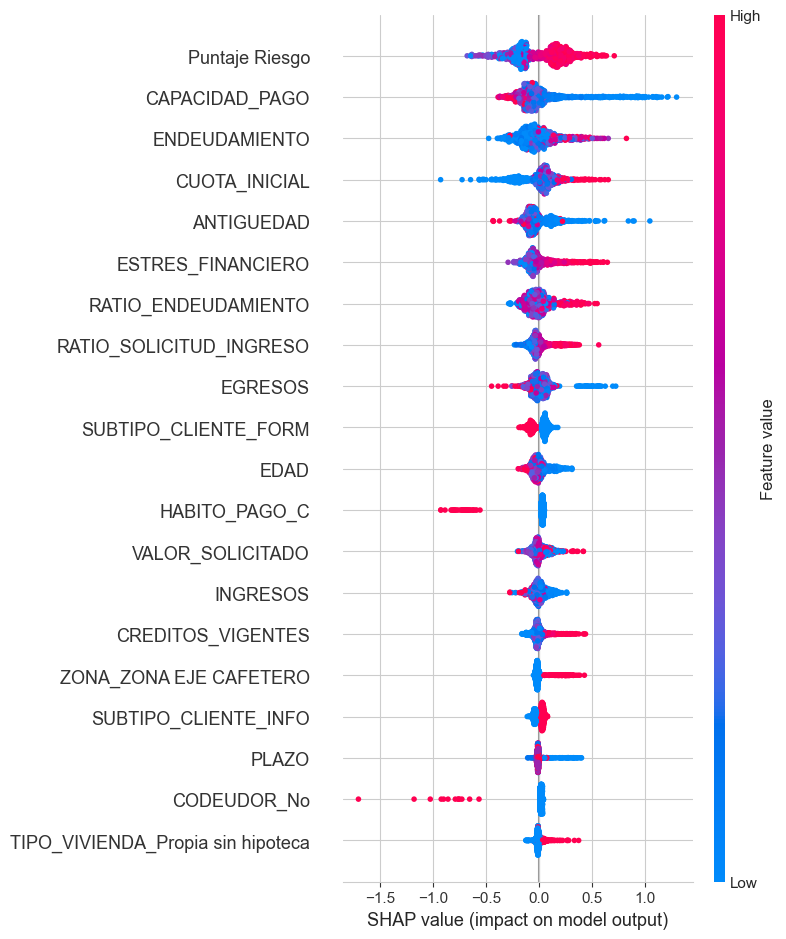

In [26]:
import shap


lgbm_model = best_model_lgbm.named_steps["classifier"]
preprocessor = best_model_lgbm.named_steps["preprocessor"]

X_test_sample = X_test.sample(min(1000, len(X_test)), random_state=42)
X_transformed = preprocessor.transform(X_test_sample)

explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_transformed)

if isinstance(shap_values, list):
    shap_to_plot = shap_values[1]
else:
    shap_to_plot = shap_values

shap.summary_plot(shap_to_plot, X_transformed, feature_names=all_feature_names)

In [27]:
modelo = best_model_lgbm
best_threshold = best_threshold_lgbm

artifact = {
    "modelo": modelo,
    "best_threshold": best_threshold,
    "feature_cols": X.columns.tolist(),
}

joblib.dump(artifact, "modelo_desistimiento_lgbm.joblib")
print("Modelo guardado en 'modelo_desistimiento_lgbm.joblib'")

Modelo guardado en 'modelo_desistimiento_lgbm.joblib'
